## Fab 4 Test Batting rankings over time - from 2012 to 2024

1) Make a list of dates
2) Make a request to 'https://www.relianceiccrankings.com/datespecific/test/batting/2016/01/01/'
3) Use BeautifulSoup to extract rankings of provided player or set of players- e.g Joe Root, Kane Williamson, Steve Smith, Virat Kohli for the given date  range
4) Store the rankings in a pandas dataframe

TODO 
- Automate plot making     
- Add a cool GUI

Handle Imports

In [40]:
import requests
import bs4 
import pandas as pd
from bs4 import BeautifulSoup
import random
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, timedelta

HEADERS = {
    'User-Agent': 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36'
}
FORMAT = 't20'              #test, odi, t20
PLAYER_TYPE = 'batting'     #batting or bowling  - n.b no date specific for all-round or women's cricket :(
BASE_URL = 'https://www.relianceiccrankings.com/datespecific/' +  FORMAT + '/' + PLAYER_TYPE + '/'
WEEKLY = True
PLAYERS = ['Joe Root', 'Kane Williamson', 'Steve Smith', 'Virat Kohli']
#PLAYERS = ['Yashasvi Jaiswal','Harry Brook']
#PLAYER_COLORS = ['yellow','red']
PLAYER_COLORS = ['red','black','green','orange']
YEAR_START = 2010
YEAR_END = 2024

### Production Code

In [3]:
def make_a_request(link):
    try:
        response = requests.get(link, headers=HEADERS)
        if response.status_code == 200:
            return response
        else:
            print(f"Error: Received status code {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None   

In [4]:
def wait_function():
    delay = random.uniform(3, 6) # Random delay 
    print(f"Sleeping for {delay:.2f} seconds...")
    time.sleep(delay)

In [5]:
def extract_table(response):
    try:
        html_content = response.content
        soup = BeautifulSoup(html_content, "html.parser") if html_content else None
        if not soup:
            return {}
        table = soup.find('table')
        if not table:
            return {}
        return table
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return {}

In [27]:
def create_links(year_start,year_end,WEEKLY = False):
    dates_links = []
    dates_for_links = []
    df_dates = []
    if WEEKLY:
        df_dates,dates_for_links= get_wednesdays(year_start,year_end)
    else: #Otherwise, run first of every month
        for year in range(year_start,year_end+1):
            for month in range(1,13):
                df_dates.append('{0}-{1:02d}-01'.format(year,month))
                dates_for_links.append('{0}/{1:02d}/01/'.format(year,month))
    dates_links = [(BASE_URL + date) for date in dates_for_links]
    return (dates_links, df_dates)

In [16]:
def get_wednesdays(start_year, end_year):
    # Set the start and end dates
    start_date = date(start_year, 1, 1)
    end_date = date(end_year, 12, 31)
    
    # Find the first Wednesday in the range
    days_to_wednesday = (2 - start_date.weekday()) % 7  # Wednesday is weekday 2
    current_date = start_date + timedelta(days=days_to_wednesday)
    
    # Collect all Wednesdays in the required formats
    df_dates = []
    dates_for_links = []
    
    while current_date <= end_date:
        # Add formatted dates to lists
        year = current_date.year
        month = current_date.month
        day = current_date.day
        df_dates.append('{0}-{1:02d}-{2:02d}'.format(year, month, day))
        dates_for_links.append('{0}/{1:02d}/{2:02d}/'.format(year, month, day))
        # Move to the next Wednesday
        current_date += timedelta(weeks=1)
    
    return df_dates, dates_for_links

In [8]:
def extract_player_ratings(table,players):
    rows = table.find_all('tr')
    players_found = 0
    player_rating_month = [None] * len(players)
    while players_found < len(players):         #Once we find all our players, stop
        for row in rows:
            #Find the 3rd column cell which contains the names
            player_name_cell = row.find_all('td')[2:3]
            if player_name_cell:
                name = player_name_cell[0].find('a')
                player_name = name.string.strip()
                #check if the name matches any of our players: if it does, extract the rating
                if player_name in players:
                    rating_cell = row.find_all('td')[1:2]
                    rating = rating_cell[0].string
                    print("Rating:{0} found for Player:{1}".format(rating,player_name))
                    players_found += 1
                    #Set the player rating into the correct column based on players
                    player_rating_month[PLAYERS.index(player_name)] = rating   
        return(player_rating_month)  

### Function to Create a plot with matplotlib

In [9]:
def create_plot(df):
    #df = pd.read_csv('brookduckett.csv')
    fig, ax = plt.subplots(figsize=(12, 6)) 
    fig.suptitle(plot_title_constructor(), fontsize=16)
    for i in range(0, len(PLAYERS)):
        if df[PLAYERS[i]].isnull().all():
            print(f"Warning: No data for player {PLAYERS[i]}")
            continue
        ax.plot(df['Date'], df[PLAYERS[i]], label=PLAYERS[i], color=PLAYER_COLORS[i])  
        
        max_player= df[PLAYERS[i]].max().astype(int)
        max_player_date = df["Date"][df[PLAYERS[i]].idxmax()]
        ax.scatter(max_player_date, max_player, color=PLAYER_COLORS[i], zorder=5)  
        ax.text(max_player_date, max_player, f' {max_player}', fontsize=10, color=PLAYER_COLORS[i], va='bottom')

    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("ICC {0} Rating".format(PLAYER_TYPE.title()), fontsize=12)
    
    ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Tick for every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year only
    ax.set_ylim(0, 1000)  
    
    fig.legend(
    loc="lower right",  # Place it at the bottom-left corner
    bbox_to_anchor=(0, 0),  # Adjust to ensure it's in the corner
    fontsize=14,
    frameon=False  # Optional: Removes the box around the legend 
    )
    # Add a text box to the bottom right of the figure
    fig.text(0.9, 0.0, 'Source: www.relianceiccrankings.com', fontsize=10, color='black', ha='right', va='bottom', 
        transform=fig.transFigure, bbox=dict(facecolor='white', boxstyle='square,pad=0.5'))
    fig.show
    #plt.savefig("plot2.png", format="png", dpi=300, bbox_inches="tight")
    



In [10]:
def plot_title_constructor():
    if len(PLAYERS) == 1:
        player_text = PLAYERS[0]
    elif len(PLAYERS) == 2:
        player_text = " and ".join(PLAYERS)
    else:
        player_text = ", ".join(PLAYERS[:-1]) + ", and " + PLAYERS[-1]
    plot_title = "ICC {0} {1} rating for {2} between {3} and {4}".format(FORMAT.title(),PLAYER_TYPE.title(),player_text,YEAR_START,YEAR_END)
    return(plot_title)

### Execution Code

In [41]:
player_ratings = []
#create links for every month between specified years
links, df_dates = create_links(YEAR_START,YEAR_END,WEEKLY)
print(links)

['https://www.relianceiccrankings.com/datespecific/t20/batting/2010/01/06/', 'https://www.relianceiccrankings.com/datespecific/t20/batting/2010/01/13/', 'https://www.relianceiccrankings.com/datespecific/t20/batting/2010/01/20/', 'https://www.relianceiccrankings.com/datespecific/t20/batting/2010/01/27/', 'https://www.relianceiccrankings.com/datespecific/t20/batting/2010/02/03/', 'https://www.relianceiccrankings.com/datespecific/t20/batting/2010/02/10/', 'https://www.relianceiccrankings.com/datespecific/t20/batting/2010/02/17/', 'https://www.relianceiccrankings.com/datespecific/t20/batting/2010/02/24/', 'https://www.relianceiccrankings.com/datespecific/t20/batting/2010/03/03/', 'https://www.relianceiccrankings.com/datespecific/t20/batting/2010/03/10/', 'https://www.relianceiccrankings.com/datespecific/t20/batting/2010/03/17/', 'https://www.relianceiccrankings.com/datespecific/t20/batting/2010/03/24/', 'https://www.relianceiccrankings.com/datespecific/t20/batting/2010/03/31/', 'https://ww

In [42]:
for link in links:
    response = make_a_request(link)
    table = extract_table(response)
    player_rating_month = extract_player_ratings(table,PLAYERS)           
    player_ratings.append(player_rating_month)
    print("Adding {0} ratings from {1}".format(player_rating_month,link))
    wait_function()  
print(player_ratings)
#export df

Adding [None, None, None, None] ratings from https://www.relianceiccrankings.com/datespecific/t20/batting/2010/01/06/
Sleeping for 5.87 seconds...
Adding [None, None, None, None] ratings from https://www.relianceiccrankings.com/datespecific/t20/batting/2010/01/13/
Sleeping for 5.00 seconds...
Adding [None, None, None, None] ratings from https://www.relianceiccrankings.com/datespecific/t20/batting/2010/01/20/
Sleeping for 3.16 seconds...
Adding [None, None, None, None] ratings from https://www.relianceiccrankings.com/datespecific/t20/batting/2010/01/27/
Sleeping for 3.84 seconds...
Adding [None, None, None, None] ratings from https://www.relianceiccrankings.com/datespecific/t20/batting/2010/02/03/
Sleeping for 5.84 seconds...
Adding [None, None, None, None] ratings from https://www.relianceiccrankings.com/datespecific/t20/batting/2010/02/10/
Sleeping for 5.82 seconds...
Adding [None, None, None, None] ratings from https://www.relianceiccrankings.com/datespecific/t20/batting/2010/02/17/


In [43]:
#Construct data frame
df = pd.DataFrame(player_ratings,columns=PLAYERS)
df = df.astype('float64')
df.insert(0,"Date",df_dates)
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
#df = df.where(pd.notnull(df), None)

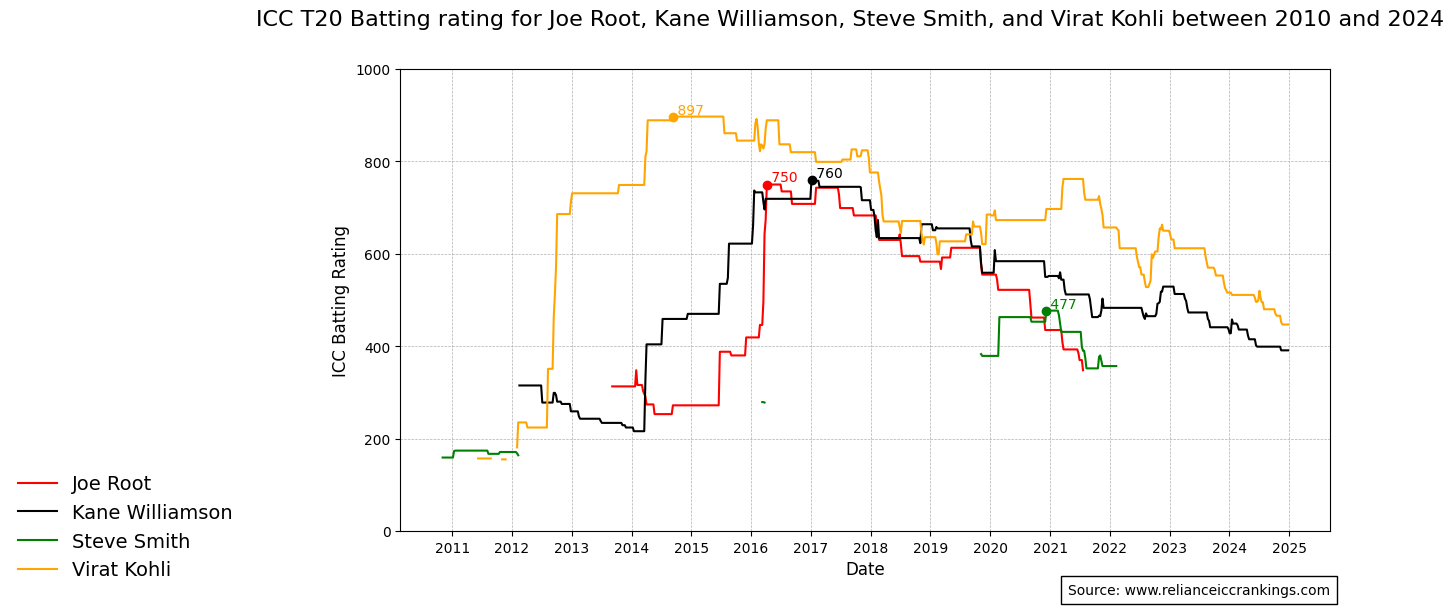

In [44]:
create_plot_choice = input("Create plot? Y/N:")
if create_plot_choice.upper() == "Y":
    create_plot(df)